In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage import io

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

/home/ctralie/anaconda3/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ctralie/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may h

torch.Size([16, 3, 128, 128])


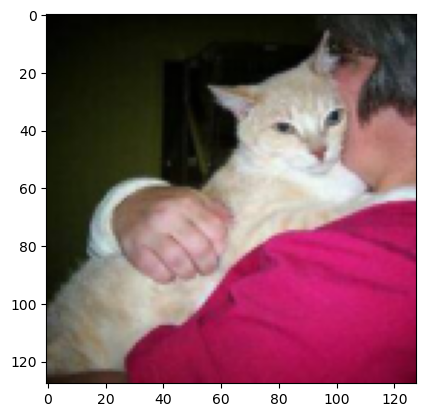

In [18]:
class CatDogData(Dataset):
    def __init__(self, foldername, imgres=128, train=True):
        cats = glob.glob("{}/cat/*".format(foldername))
        dogs = glob.glob("{}/dog/*".format(foldername))
        self.labels  = [0]*len(cats)
        self.labels += [1]*len(dogs)
        self.images = cats + dogs
        self.labels = torch.from_numpy(np.array(self.labels, dtype=np.float32))
        
        if train:
            self.augmenter = v2.Compose(
                  [v2.ToImageTensor(), 
                   v2.RandomResizedCrop(size=(128, 128), scale=(0.8, 1), antialias=True),
                   v2.ToDtype(torch.float32),
                   v2.Lambda(lambda x: x[0:3, :, :])
                   ])
        else:
            self.augmenter = v2.Compose(
                  [v2.ToImageTensor(), 
                   v2.Resize(size=(128)),
                   v2.CenterCrop(size=(128, 128)),
                   v2.ToDtype(torch.float32),
                   v2.Lambda(lambda x: x[0:3, :, :])
                   ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = io.imread(self.images[idx])
        img = self.augmenter(img)
        if torch.max(img) > 1:
            img /= 255
        return img, self.labels[idx]
         
traindata = CatDogData("catdog/train", train=True)
testdata  = CatDogData("catdog/test", train=False)


loader = DataLoader(traindata, batch_size=16)
X, Y = next(iter(loader))
print(X.shape)
plt.imshow(np.moveaxis(X[10, :, :, :].numpy(), 0, 2))

In [3]:
class BetterModel(nn.Module):
    def __init__(self, imgres=128, n_channels=3):
        super().__init__()
        
        layers = [nn.Conv2d(3, 32, kernel_size=3, stride=1),
                  nn.LeakyReLU(),
                  nn.MaxPool2d(2),
                  nn.Dropout(0.2),
                  nn.Conv2d(32, 64, kernel_size=3, stride=1),
                  nn.LeakyReLU(),
                  nn.MaxPool2d(2),
                  nn.Dropout(0.2),
                  nn.Conv2d(64, 128, kernel_size=3, stride=1),
                  nn.LeakyReLU(),
                  nn.MaxPool2d(2),
                  nn.Dropout(0.2),
                  nn.Conv2d(128, 256, kernel_size=3, stride=1),
                  nn.LeakyReLU(),
                  nn.MaxPool2d(2),
                  nn.Dropout(0.2)
                 ]
        cnn = nn.Sequential(*layers)
        # Apply layers to a test image to get shape of final output of cnn part
        img = torch.rand(1, n_channels, imgres, imgres)
        img = cnn(img)
        self.cnn = nn.Sequential(*layers)
        self.linear1 = nn.Linear(np.prod(img.shape[1::]), 128)
        self.droplinear = nn.Dropout(0.5)
        self.linear2 = nn.Linear(128, 1)
    
    def forward(self, x):
        y = self.cnn(x)
        y = y.view(y.shape[0], np.prod(y.shape[1::]))
        y = self.linear1(y)
        y = self.droplinear(y)
        return self.linear2(y)[:, 0]

In [4]:
device = 'cuda'

model = BetterModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = torch.nn.BCEWithLogitsLoss() 

n_epochs = 50
train_losses = np.zeros(n_epochs)
train_accuracy = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)
test_accuracy = np.zeros(n_epochs)

batch_size = 32

for epoch in range(n_epochs):
    model.train()
    
    loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
    total_loss = 0
    num_correct = 0
    total = 0
    for i, (X, Y) in enumerate(loader):
        total += X.shape[0]
        X = X.to(device)
        Y = Y.to(device)
        # Go through each batch
        Y_est = model(X)
        # Sum up the losses for each example
        loss = loss_fn(Y_est, Y)
        # Compute the number of examples that are correct
        num_correct += torch.sum(torch.round(torch.sigmoid(Y_est)) == Y).item()
        
        # Compute the gradient of the loss function 
        # with respect to all parameterse in the optimizer
        loss.backward()
        total_loss += loss.item() # (Don't keep taking gradients)
        
        # Apply gradient descent
        optimizer.step()
        #print("Microbatch {} allocated memory step: {:.3f}".format(i, torch.cuda.memory_allocated(device)/1e9))
        # Clear accumulated gradients for next time
        optimizer.zero_grad()
        del X
        del Y
        torch.cuda.empty_cache()
        
    print("Finished epoch {}".format(epoch))
    train_losses[epoch] = total_loss / total
    train_accuracy[epoch] = num_correct / total
    
    with torch.no_grad():
        model.eval()
        loader = DataLoader(testdata, batch_size=batch_size)
        num_correct = 0
        loss = 0
        total = 0
        for X, Y in loader:
            X, Y = next(iter(loader))
            X = X.to(device)
            Y = Y.to(device)
            Y_est = model(X)
            loss += loss_fn(Y_est, Y).item()
            num_correct += torch.sum(torch.round(torch.sigmoid(Y_est)) == Y).item()
            total += X.shape[0]
        test_losses[epoch] = loss/total
        test_accuracy[epoch] = num_correct/total
    torch.save(model, "epochs/better{}.pkl".format(epoch))
    
    print("Epoch {}, train loss {:.3f}, train accuracy {:.3f}, test loss {:.3f}, test accuracy {:.3f}".
          format(epoch, train_losses[epoch], train_accuracy[epoch], test_losses[epoch], test_accuracy[epoch]))



Finished epoch 0


/home/ctralie/anaconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0, train loss 0.020, train accuracy 0.613, test loss 0.018, test accuracy 0.812
Finished epoch 1
Epoch 1, train loss 0.017, train accuracy 0.730, test loss 0.013, test accuracy 0.844
Finished epoch 2
Epoch 2, train loss 0.015, train accuracy 0.772, test loss 0.007, test accuracy 0.938
Finished epoch 3
Epoch 3, train loss 0.013, train accuracy 0.802, test loss 0.009, test accuracy 0.938
Finished epoch 4
Epoch 4, train loss 0.012, train accuracy 0.829, test loss 0.005, test accuracy 0.969
Finished epoch 5
Epoch 5, train loss 0.011, train accuracy 0.847, test loss 0.004, test accuracy 0.938
Finished epoch 6
Epoch 6, train loss 0.010, train accuracy 0.860, test loss 0.006, test accuracy 0.938
Finished epoch 7
Epoch 7, train loss 0.009, train accuracy 0.874, test loss 0.003, test accuracy 0.969
Finished epoch 8
Epoch 8, train loss 0.008, train accuracy 0.882, test loss 0.003, test accuracy 0.969
Finished epoch 9
Epoch 9, train loss 0.008, train accuracy 0.893, test loss 0.004, test ac

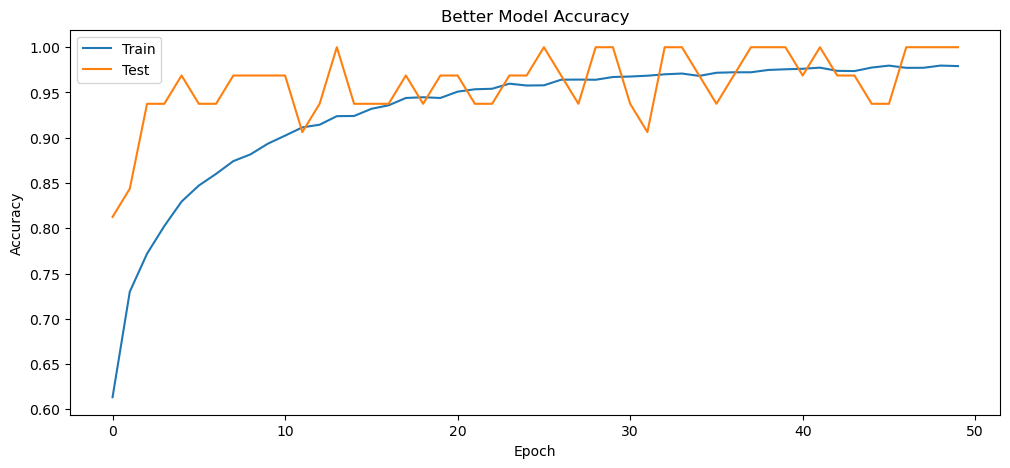

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.legend(["Train", "Test"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Better Model Accuracy")
plt.savefig("BetterModel.svg", bbox_inches='tight')
torch.save(model, "better.pkl")

In [19]:
device = 'cuda'
model = torch.load("epochs/better49.pkl")
model = model.to(device)
model.eval()

AttributeError: Can't get attribute 'BetterModel' on <module '__main__'>

In [21]:
our_examples = CatDogData("ourexamples", train=True)

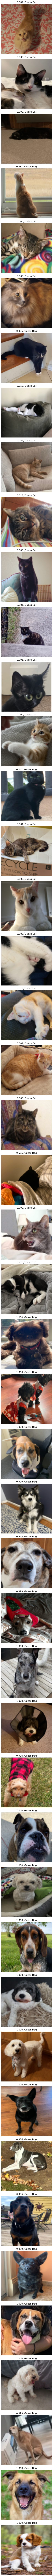

In [22]:
model.eval()
loader = DataLoader(our_examples, batch_size=len(our_examples))
X, Y = next(iter(loader))
X = X.to(device)
Y_est = torch.sigmoid(model(X))

res = 4
plt.figure(figsize=(res, res*X.shape[0]))
for i in range(X.shape[0]):
    plt.subplot(X.shape[0], 1, i+1)
    Xi = X[i, :, :, :].detach().cpu().numpy()
    Xi = np.moveaxis(Xi, 0, 2)
    plt.imshow(Xi)
    guess = ["Cat", "Dog"][int(torch.round(Y_est[i]).item())]
    plt.title("{:.3f}, Guess {}".format(Y_est[i], guess))
    plt.axis("off")
plt.tight_layout()
plt.savefig("Guesses.png")